<a href="https://colab.research.google.com/github/Eran707/MSc-Computational-Neuroscience-Repo/blob/master/V3_Single_Compartment_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single compartment pump leak model

Coded by Eran Shorer (piggybacking on Kira Dusterwald and Alan Kay)

## Introduction

Herein I attempt to model the dynamics of a single neuron with emphasis Chloride homeostasis to better understand processes occuring in epilepsy. 

A Neuron is a type of cell in the nervous system that is able to communicate with other neurons via electrochemical signals. 
The trillions of communications that occur in the brain give rise to complex animal behaviours.
Errors in this signalling pathway therefore can lead disorders in the nervous system.
To understand how a network of cells function we can start off by understanding the dynamics of a single neuron. 





![alt text](https://drive.google.com/uc?id=1GT7WU9e0qYCdLHlDstU_SonNyBc5PP3b)

Above we have the cell body of a single neuron. 

(A) Ions:


*   Sodium (Na), charge of +1
*   Potassium (K), charge of +1
*   Chloride (Cl), charge of -1
*   Impermeant anions (X) charge of z

(B) ATPase: 

ATP dependant Sodium Potassium Pump which pumps 3 Na out of the neuron for every 2 K it pumps in.

(C) KCC2:

Potassium-Chloride Cotransporter 2. Pumps out potassium and chloride.



## Module installation:

numpy - for mathematical operations
matplotlib - for graphing
seaborn - for graphing

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
print('modules installed')

modules installed


## Constants:

R = Gas Constant
F = Faradays Constant
T = Temperature in Kelvin
RTF is used as a combined variable


In [8]:
R = 8.31466  # J/(Kelvin.mol) #Universal Gas Constant
F = 96485.33 #C/mol # Faraday Constant in Volts
T = 310.15   #Kelvin # Absolute temperature (37C)
RTF = R*T/F  # J/C
print('Constants set')

Constants set


## Parameters:

### Cellular dimensions
We will be using a sphere as the model of the cell. 
The area of the sphere (SA) will be fixed but the volume (w) will change based on the osmotic properties of the cell.
C_m refers to the membrane capacitance and the FinvCSA is a composite parameter.


![alt text](https://drive.google.com/uc?id=1G0SIsSn9tm8BjiREZz3ttojXAurrEjkj)

In [0]:
rad = 5*1e-5            #Radius of the single compartment (um converted to dm)
w = (4/3)*np.pi*rad**3  #L #Volume of a single compartment (Sphere)
SA = 4*np.pi*rad**2     #dm^2 #Surface area of a sphere 
C_m = 1e-4              #(F/dm^2) #Unit of membrane capacitance
FinvCSA = F/(C_m*SA)

Q: Why are we using a sphere and not a cylinder?


### Ionic properties 

Here I will define the baseline Osmolarity and hence calculate the concentrations of the ions of interest (Na+, K+, Cl-, and X(impermeant anions)). Both the extracellular and intracellular osmolarities are calculated here.
We start by setting the osmolarity to be 300 x 10^-3 Molar. 
Omsols of negative and positive ions must be 150 X10^-3 Molar respectively. 

In [3]:
OsmolO = 300e-3     #M #Fixed osmolarity

ConcO_K = 3e-3      #M 
ConcO_X = 0         #M #No anions outside cell
zO_X = 0            #charge of extracellular anions
ConcO_Cl=(OsmolO-ConcO_X)/2 # calc clo from charge and osmotic balance 
ConcO_Na = ConcO_Cl-ConcO_K-ConcO_X*zO_X # calc nao 

ConcI_X = 50*1e-3   #Concentration of intracellular anion (M)
ConcI_Cl = (OsmolO - 2*ConcI_X)/2
ConcI_Na = 0.8*(OsmolO-ConcI_Cl-ConcI_X)
ConcI_K = 0.2*(OsmolO-ConcI_Cl-ConcI_X)

print("Extracellular concentrations: (Molar)")
print("---------------------")
print('Na: ',ConcO_Na)
print('K: ',ConcO_K)
print('Cl: ', ConcO_Cl)
print('X: ', ConcO_X)
print("")
print("Intracellular concentrations: (Molar)")
print("---------------------")
print('Na: ',ConcI_Na)
print('K: ',ConcI_K)
print('Cl: ', ConcI_Cl)
print('X: ', ConcI_X)
print("")

Extracellular concentrations: (Molar)
---------------------
Na:  0.147
K:  0.003
Cl:  0.15
X:  0

Intracellular concentrations: (Molar)
---------------------
Na:  0.12000000000000002
K:  0.030000000000000006
Cl:  0.09999999999999999
X:  0.05



### Channel and pump properties

In [4]:
g_Na = 0.01*0.1/F # S/dm2 #Na Leak conductance ### Not too sure why I need to / by F (according to Kira and Alan)
g_K = 0.3*0.1/F     # S/dm2 #K Leak conductance
g_Cl = 0.2*0.1/F   # S/dm2 #Cl Leak conductance

curr = -0*5e-8; #Baseline no current injected
p = 0.5e-4/F # Alan's pump rate (C/dm^2)
g_KCC2 = 2e-3/F #KCC2 conductance from Kira's code

NameError: ignored

## Variable initialization:


### Timing related variables

In [7]:
#### - Timing related variables
t = 1               # real time in seconds
totalt = 10000          # total time
dt = 1e-3           # time step
t_on = 0            # time when the ATPase is switched on
t_off = 5000        # time when the ATPase is switched off
totalsteps = round(totalt/dt)  # total number of time steps
sw = 0              # 0 = switch off; 1 = switch on
ctr = 1     # counter for plotting 
n = 200     # number of plot points
ts = totalt/n   # time interval for plotting

print('Simulation will run for ',totalt,' seconds') 
print('The timestep will be', dt, 'seconds')
print('The ATPase pump is switched on at', t_on, 'seconds')
print('The ATPase pump is switched off at', t_off, 'seconds')

Simulation will run for  10000  seconds
The timestep will be 0.001 seconds
The ATPase pump is switched on at 0 seconds
The ATPase pump is switched off at 5000 seconds


### Array initialization

In [8]:
Na_Arr = []
K_Arr = []
Cl_Arr = []
X_Arr = []
Vm_Arr = []
t_Arr = []           
w_Arr = []

print('All arrays are empty to begin with')

All arrays are empty to begin with


# Simulation 

In order to calculate how the system changes with time I use a use a Euler approach with the following differential equaitons

**Calculating the membrane voltage change:**

\begin{equation}
\frac{\delta V_{m}}{\delta t}= \frac{F}{C_{m} SA} \times w \times ([Na] + [K] - [Cl] + z[X]) \\
\end{equation}

**Calculating the KCC2 Pump rate**

\begin{align}
E_{K} &= RTF \times log(\frac{[K]_{o}}{[K]_{i}})\\
E_{Cl} &= RTF \times log(\frac{[Cl]_{o}}{[Cl]_{i}})\\
J_{KCC2} &= g_{KCC2}\times(E_{K}-E_{Cl})\\
\nonumber
\end{align}

**Calculating changes to intracellular ion concentrations**
\begin{align}
\frac{\delta [Na]}{\delta t}&= -\dfrac{SA}{w}\times(g_{Na} \times(V_{m} - \dfrac{RT}{F} log(\dfrac{[Na]_{o}}{[Na]_{i}}) + 3J_{p}) \\
\frac{\delta [K]}{\delta t}&= -\dfrac{SA}{w} \times (g_{K} \times (V_{m} - \dfrac{RT}{F} log(\dfrac{[K]_{o}}{[K]_{i}}) + 2J_{p} - J_{KCC2}) \\
\frac{\delta [Cl]}{\delta t}&= \dfrac{SA}{w} \times  (g_{Cl} \times(V_{m} - \dfrac{RT}{F} log(\dfrac{[Cl]_{o}}{[Cl]_{i}}) - J_{KCC2}) \\
\nonumber
\end{align}




### Calculating the starting voltage

In [9]:
Vm = FinvCSA*w*(ConcI_Na+ConcI_K-ConcI_Cl-ConcI_X) 
print('Starting voltage of', Vm, 'mV')

Starting voltage of 4.4633431210231817e-13 mV


### Looping through time

In [0]:
for i in range(1,totalsteps):  #note tit = total number of timesteps
     
    #Determining switch position of ATPase
    if (t<t_off) & (t>t_on): 
        sw=1 
    else: 
        sw=0
            
    # Voltage Calculation 
    Vm = FinvCSA*w*(ConcI_Na+ConcI_K-ConcI_Cl-ConcI_X)
    
    # KCC2 pump rate calculation 
    EK = RTF*np.log(ConcO_K/ConcI_K)
    ECl = RTF*np.log(ConcO_Cl/ConcI_Cl)
    JKCC2 = g_KCC2*(EK-ECl)
        
    #Incrementing Ion concentration    
    d_Na = -dt*SA*(1/w)*(g_Na*(Vm-RTF*np.log(ConcO_Na/ConcI_Na)) + sw*3*p) 
    d_K = -dt*SA*(1/w)*(g_K*(Vm-RTF*np.log(ConcO_K/ConcI_K))-JKCC2+sw*2*p+sw*curr) 
    d_Cl = dt*SA*(1/w)*(g_Cl*(Vm+RTF*np.log(ConcO_Cl/ConcI_Cl))+JKCC2)
    ConcI_Na += d_Na    
    ConcI_K += d_K
    ConcI_Cl += d_Cl      
     
    #Osmolarity and volume adjustments
    OsmolI = ConcI_Na+ConcI_K+ConcI_Cl+ConcI_X
    w2 = w*(OsmolI/OsmolO)
    
    #Adjusting Concentrations based on new volumes
    ConcI_Na *= w/w2
    ConcI_K *= w/w2
    ConcI_Cl *= w/w2
    ConcI_X *= w/w2
    
    #Updating Arrays and counters
    w = w2
    
    if t >= ctr*ts :
        Vm_Arr.append(Vm*1e3)
        K_Arr.append(ConcI_K*1e3)
        Na_Arr.append(ConcI_Na*1e3)
        Cl_Arr.append(ConcI_Cl*1e3)
        X_Arr.append(ConcI_X*1e3)
        w_Arr.append(100*(1e5)*((3/(4*np.pi))*w)**(1/3))
        t_Arr.append(t)
        ctr += 1
    
        
    t = t+dt      

## Plotting results

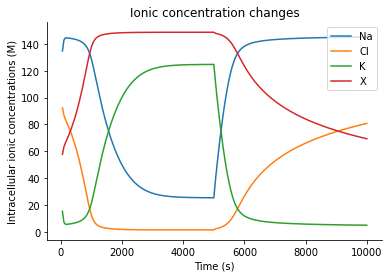

In [13]:
plt.plot(t_Arr,Na_Arr,label ="Na")
plt.plot(t_Arr,Cl_Arr,label="Cl")
plt.plot(t_Arr,K_Arr,label="K")
plt.plot(t_Arr,X_Arr,label="X")
plt.title("Ionic concentration changes")
plt.xlabel("Time (s)")
plt.ylabel("Intracellular ionic concentrations (M)")
plt.legend(loc = 'upper right')
sns.despine()

